In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint ,  solve_ivp

In [4]:
def opto_non_linear(t,z,g_z0,g_z1,g_y,del_omega,N0):
    q_z,p_z,q_y,p_y,a_0,a_p1,a_m1,a_0_d,a_p1_d,a_m1_d=z
    n_0=a_0_d*a_0
    sigma_m=1j*(a_0_d*(a_p1-a_m1)-a_0*(a_p1_d-a_m1_d))
    N_eff=g_z1*(a_p1*a_p1_d+a_m1*a_m1_d)+g_z0*n_0
    q_y_dot     =p_y
    p_y_dot     =-q_y-g_y*sigma_m*N0
    
    q_z_dot     =p_z
    p_z_dot     =-q_z-2*N_eff*N0

    a_0_dot=-1j*(del_omega+g_z0*q_z)*a_0+g_y*q_y*(a_p1-a_m1)/2
    a_p1_dot=-1j*g_z1*q_z*a_p1-g_y*q_y*a_0/2
    a_m1_dot=-1j*g_z1*q_z*a_m1+g_y*q_y*a_0/2
    
    a_0_d_dot=1j*(del_omega+g_z0*q_z)*a_0_d+g_y*q_y*(a_p1_d-a_m1_d)/2
    a_p1_d_dot=1j*g_z1*q_z*a_p1_d-g_y*q_y*a_0_d/2
    a_m1_d_dot=1j*g_z1*q_z*a_m1_d+g_y*q_y*a_0_d/2

    
    x_list=[q_z_dot,p_z_dot,q_y_dot,p_y_dot,a_0_dot,a_p1_dot,a_m1_dot,a_0_d_dot,a_p1_d_dot,a_m1_d_dot]
    return x_list

# def opto_non_linear_2(t,z,g_z0,g_z1,g_y,del_omega,N0):
#     ##less accurate
#     q,p,a_0,a_p1,a_m1=z
    
#     a_0_d=np.conj(a_0)
#     a_p1_d=np.conj(a_0)
#     a_m1_d=np.conj(a_0)
    
#     n_0=a_0_d*a_0
#     sigma_m=1j*(a_0_d*(a_p1-a_m1)-a_0*(a_p1_d-a_m1_d))
#     q_dot     =-p
#     p_dot     =q+g_y*sigma_m*N0
    
#     a_0_dot   = 1j*a_0*(-del_omega + ((g_z0-g_z1)**2*(2*n_0*N0+1)+2*g_z1*(g_z0-g_z1)*(N0+n_0*N0+1)) )  + g_y*q*(a_p1-a_m1)/2
#     a_p1_dot  = 1j*a_p1*(2*g_z1*(g_z0-g_z1)*n_0*N0 )    - g_y*q*a_0/2
#     a_m1_dot  = 1j*a_m1*(2*g_z1*(g_z0-g_z1)*n_0*N0 )    + g_y*q*a_0/2
    
    
#     x_list=[q_dot,p_dot,a_0_dot,a_p1_dot,a_m1_dot]
#     return x_list


def opto_linear(t,z,g_z0,g_z1,g_y, del_omega,N0):
    q,p,a_0,a_p1,a_m1,a_0_d,a_p1_d,a_m1_d=z
    delta=del_omega-2*g_z1*(g_z0-g_z1)*N0-(g_z0**2-g_z1**2)
    sigma_m=1j*(a_p1-a_m1-a_p1_d-a_m1_d)
    q_dot     =-p
    p_dot     =q+g_y*sigma_m*N0
    
    a_0_dot   = 0
    a_p1_dot  = 1j*a_p1*delta    - g_y*q/2
    a_m1_dot  = 1j*a_m1*delta   + g_y*q/2
    
    a_0_d_dot =  0
    a_p1_d_dot= -1j*a_p1_d*delta- g_y*q/2
    a_m1_d_dot= -1j*a_m1_d*delta + g_y*q/2
    

    x_list=[q_dot,p_dot,a_0_dot,a_p1_dot,a_m1_dot,a_0_d_dot,a_p1_d_dot,a_m1_d_dot]
    return x_list

    
def evolve(x_0,a,tf,param_list,N_step=300,linear=False):
    q_z_0,p_z_0,q_y_0,p_y_0=x_0
    g_z0,g_z1,g_y, del_omega, N0=param_list
    z0=np.array([q_z_0,p_z_0,q_y_0,p_y_0,a[0],a[1],a[-1],a[0].conj(),a[1].conj(),a[-1].conj()])
#     z0=np.array([q_0,p_0,a[0],a[1],a[-1],a[0].conj(),a[1].conj(),a[-1].conj()])
    t = np.linspace(0,tf,N_step)
    func= opto_linear if linear else opto_non_linear
    xx=solve_ivp(func, [0,tf],z0,args=param_list,dense_output=True,rtol = 1e-8, atol = 1e-8, t_eval=t)
    zz=xx.sol(t)
    sol=[]
    sol.extend( (np.real(zz[0]),np.real(zz[1]),np.real(zz[2]),np.real(zz[3])) )
#     E_mech=(p**2+q**2)/4
    n_0=zz[4]*zz[7]
    n_p1=zz[5]*zz[8]
    n_m1=zz[6]*zz[9]
    #E_opt=omega_1*(n_p1+n_m1)+omega_0*n_0
    N=n_0+n_p1+n_m1
    sigma_m=1j*(zz[7]*(zz[5]-zz[6])-zz[4]*(zz[8]-zz[9]))
    sol.extend( (np.abs(1-n_0),np.abs(n_p1),np.abs(n_m1),np.abs(sigma_m)) )
    return sol,t


def lyapunov(param_list):
    g_z0,g_z1,g_y,del_omega,N0=param_list
    E=[]
    delta=del_omega-2*N0*g_z1*(g_z0-g_z1)+g_z0**2-g_z1**2
    lam_p1=(((1+delta**2)+((1-delta**2)**2-8*delta*g_y**2*N0)**0.5)/2)**0.5
    lam_p2=-lam_p1
    lam_m1=(((1+delta**2)-((1-delta**2)**2-8*delta*g_y**2*N0)**0.5)/2)**0.5
    lam_m2=-lam_m1
    E.append(lam_p1)
    E.append(lam_p2)
    E.append(lam_m1)
    E.append(lam_m2)
    return E

def Pc(param_list):
    g_z0,g_z1,g_y,del_omega,N0=param_list
    delta=del_omega-2*N0*g_z1*(g_z0-g_z1)+g_z0**2-g_z1**2
    #Pc=g_y**2*N_0/delta
    Pc=(8*delta*g_y**2*N0)/(1-delta**2)**2
    return Pc

def freq(param_list):
    g_z0,g_z1,g_y,del_omega,N0=param_list
    delta=del_omega+2*N0*g_z1*(g_z0-g_z1)+(g_z0**2-g_z1**2)
    w_m=1-g_y**2*N0/delta
    w_p=delta+g_y**2*N0/delta**2
    return w_m,w_p

In [5]:
g_y=1.24e6   ##Hz
omega_0=4.45e15 ##Hz
del_omega=1e8
omega_1=omega_0-del_omega ##Hz
ohm=1e6         ##Hz
g_z0=0
g_z1=(20*ohm)**0.5
delta_0=100*ohm
N0=1e1

g_y/=ohm
g_z1/=ohm
g_z0/=ohm
omega_1/=ohm
omega_0/=ohm
del_omega/=ohm

label_list=["$Q$","$P$","$1-n_0$","$n_1$","$n_{-1}$","$\sigma_-$","E_mech"]


$\lambda_{\pm}^2=\frac{(1+\Delta^2)\pm \sqrt{(1-\Delta^2)^2-8\Delta g_y^2 N_0}}{2}$
$\newline$
$\Delta=\delta_\omega-2N_0 g_1^z(g_0^z-g_1^z)+(g_0^z)^2-(g_1^z)^2$


In [50]:
del_omega

100.0

In [54]:
x_0=[0.+0j,0.+0j,1.612*1e-1+0j,0.+0j]
q_z_0,p_z_0,q_y_0,p_y_0=x_0
print(q_z_0,p_z_0,q_y_0,p_y_0)

0j 0j (0.1612+0j) 0j


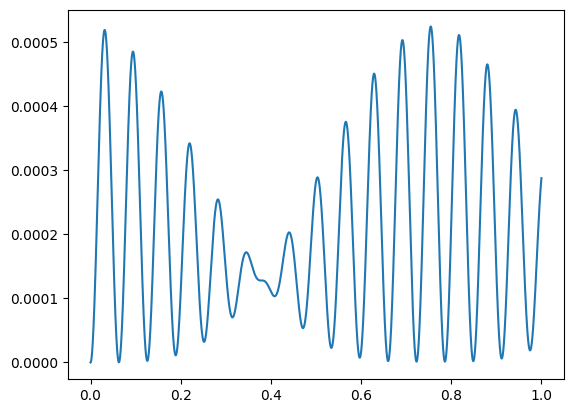

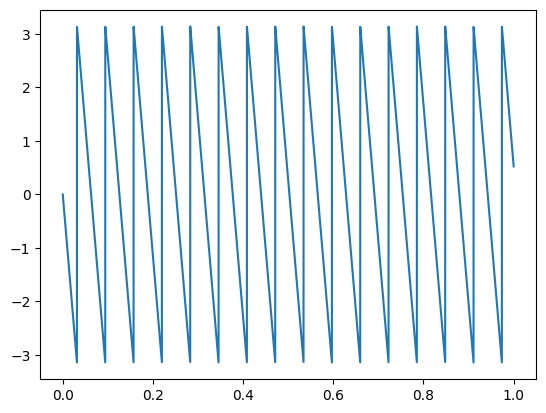

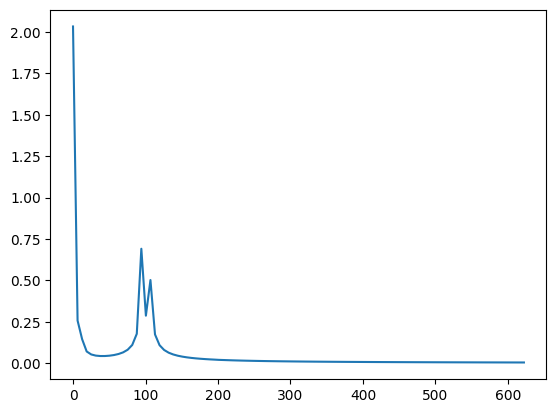

In [82]:
# label_list=["$|a_1|$","$|a_{-1}|$","$arg(a_1)$","$arg(a_{-1})$",]

tf=1e0
N_step=10000
g_y=1e1
N0=8
x_0=[0.+0j,0.+0j,1.612*1e-1+0j,0.+0j]
a_0=np.array([1+0j,0+0j,0+0j])
param_list=[g_z0,g_z1,g_y,del_omega,N0] 
#########
q_z_0,p_z_0,q_y_0,p_y_0=x_0
z0=np.array([q_z_0,p_z_0,q_y_0,p_y_0,a_0[0],a_0[1],a_0[-1],a_0[0].conj(),a_0[1].conj(),a_0[-1].conj()])
t = np.linspace(0,tf,N_step)
xx=solve_ivp(opto_non_linear, [0,tf],z0,args=param_list,dense_output=True,rtol = 1e-8, atol = 1e-8, t_eval=t)
zz=xx.sol(t)
sol=[]
# sol.extend( (np.abs(zz[]),np.abs(n_p1),np.abs(n_m1),np.abs(sigma_m)) )
# sol.extend( ( np.abs(zz[5]*zz[8]-zz[6]*zz[9]),np.abs(zz[5]),np.abs(zz[5]-zz[6]),np.angle(zz[5]-zz[6]) ) )
##########
# l=len(sol)
# fig, axs = plt.subplots(l//2, 2,figsize=(20,4*l))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
# for i in range(l):
#     axs[i//2,i%2].plot(t,sol[i],label="P_c"+'='+"{:.1e}".format(Pc(param_list)))
# #     axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
#     axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
#     axs[i//2,i%2].legend(fontsize=12)

# plt.show() 
#########
plt.plot(t,1-np.abs(zz[4]*zz[7]))
plt.show()
plt.plot(t,np.angle(zz[4]))
plt.show()
# plt.plot(np.real(zz[4]),np.imag(zz[4]))
# plt.axis("equal")
# plt.xlim([0.9,1.1])
# plt.ylim([-0.1,0.1])
# plt.show()
# plt.plot(t[:],np.real(zz[4])[:],t[:],np.imag(zz[4])[:])
# plt.show()
z_f=np.abs(np.fft.fft(1-np.abs(zz[4]*zz[7])))
omega=2*np.pi*np.arange(N_step)/tf
plt.plot(omega[:100],z_f[:100])
plt.show()
# z_f=np.abs(np.fft.fft(zz[4].real))
# omega=2*np.pi*np.arange(N_step)/tf
# plt.plot(omega,z_f/2)
# plt.show()
# z_f=np.angle(np.fft.fft(zz[4].imag))
# omega=2*np.pi*np.arange(N_step)/tf
# plt.plot(omega,z_f)
# plt.show()
# z_f=np.angle(np.fft.fft(zz[4]))
# omega=2*np.pi*np.arange(N_step)/tf
# plt.plot(omega,z_f/2)
# plt.show()
# plt.plot(t,np.imag(zz[5]),t,-np.imag(zz[8]))
# plt.show()
# plt.plot(t,np.angle(zz[8]),t,np.angle(zz[9]))
# plt.show()


In [49]:
2*np.pi/0.06

104.71975511965978

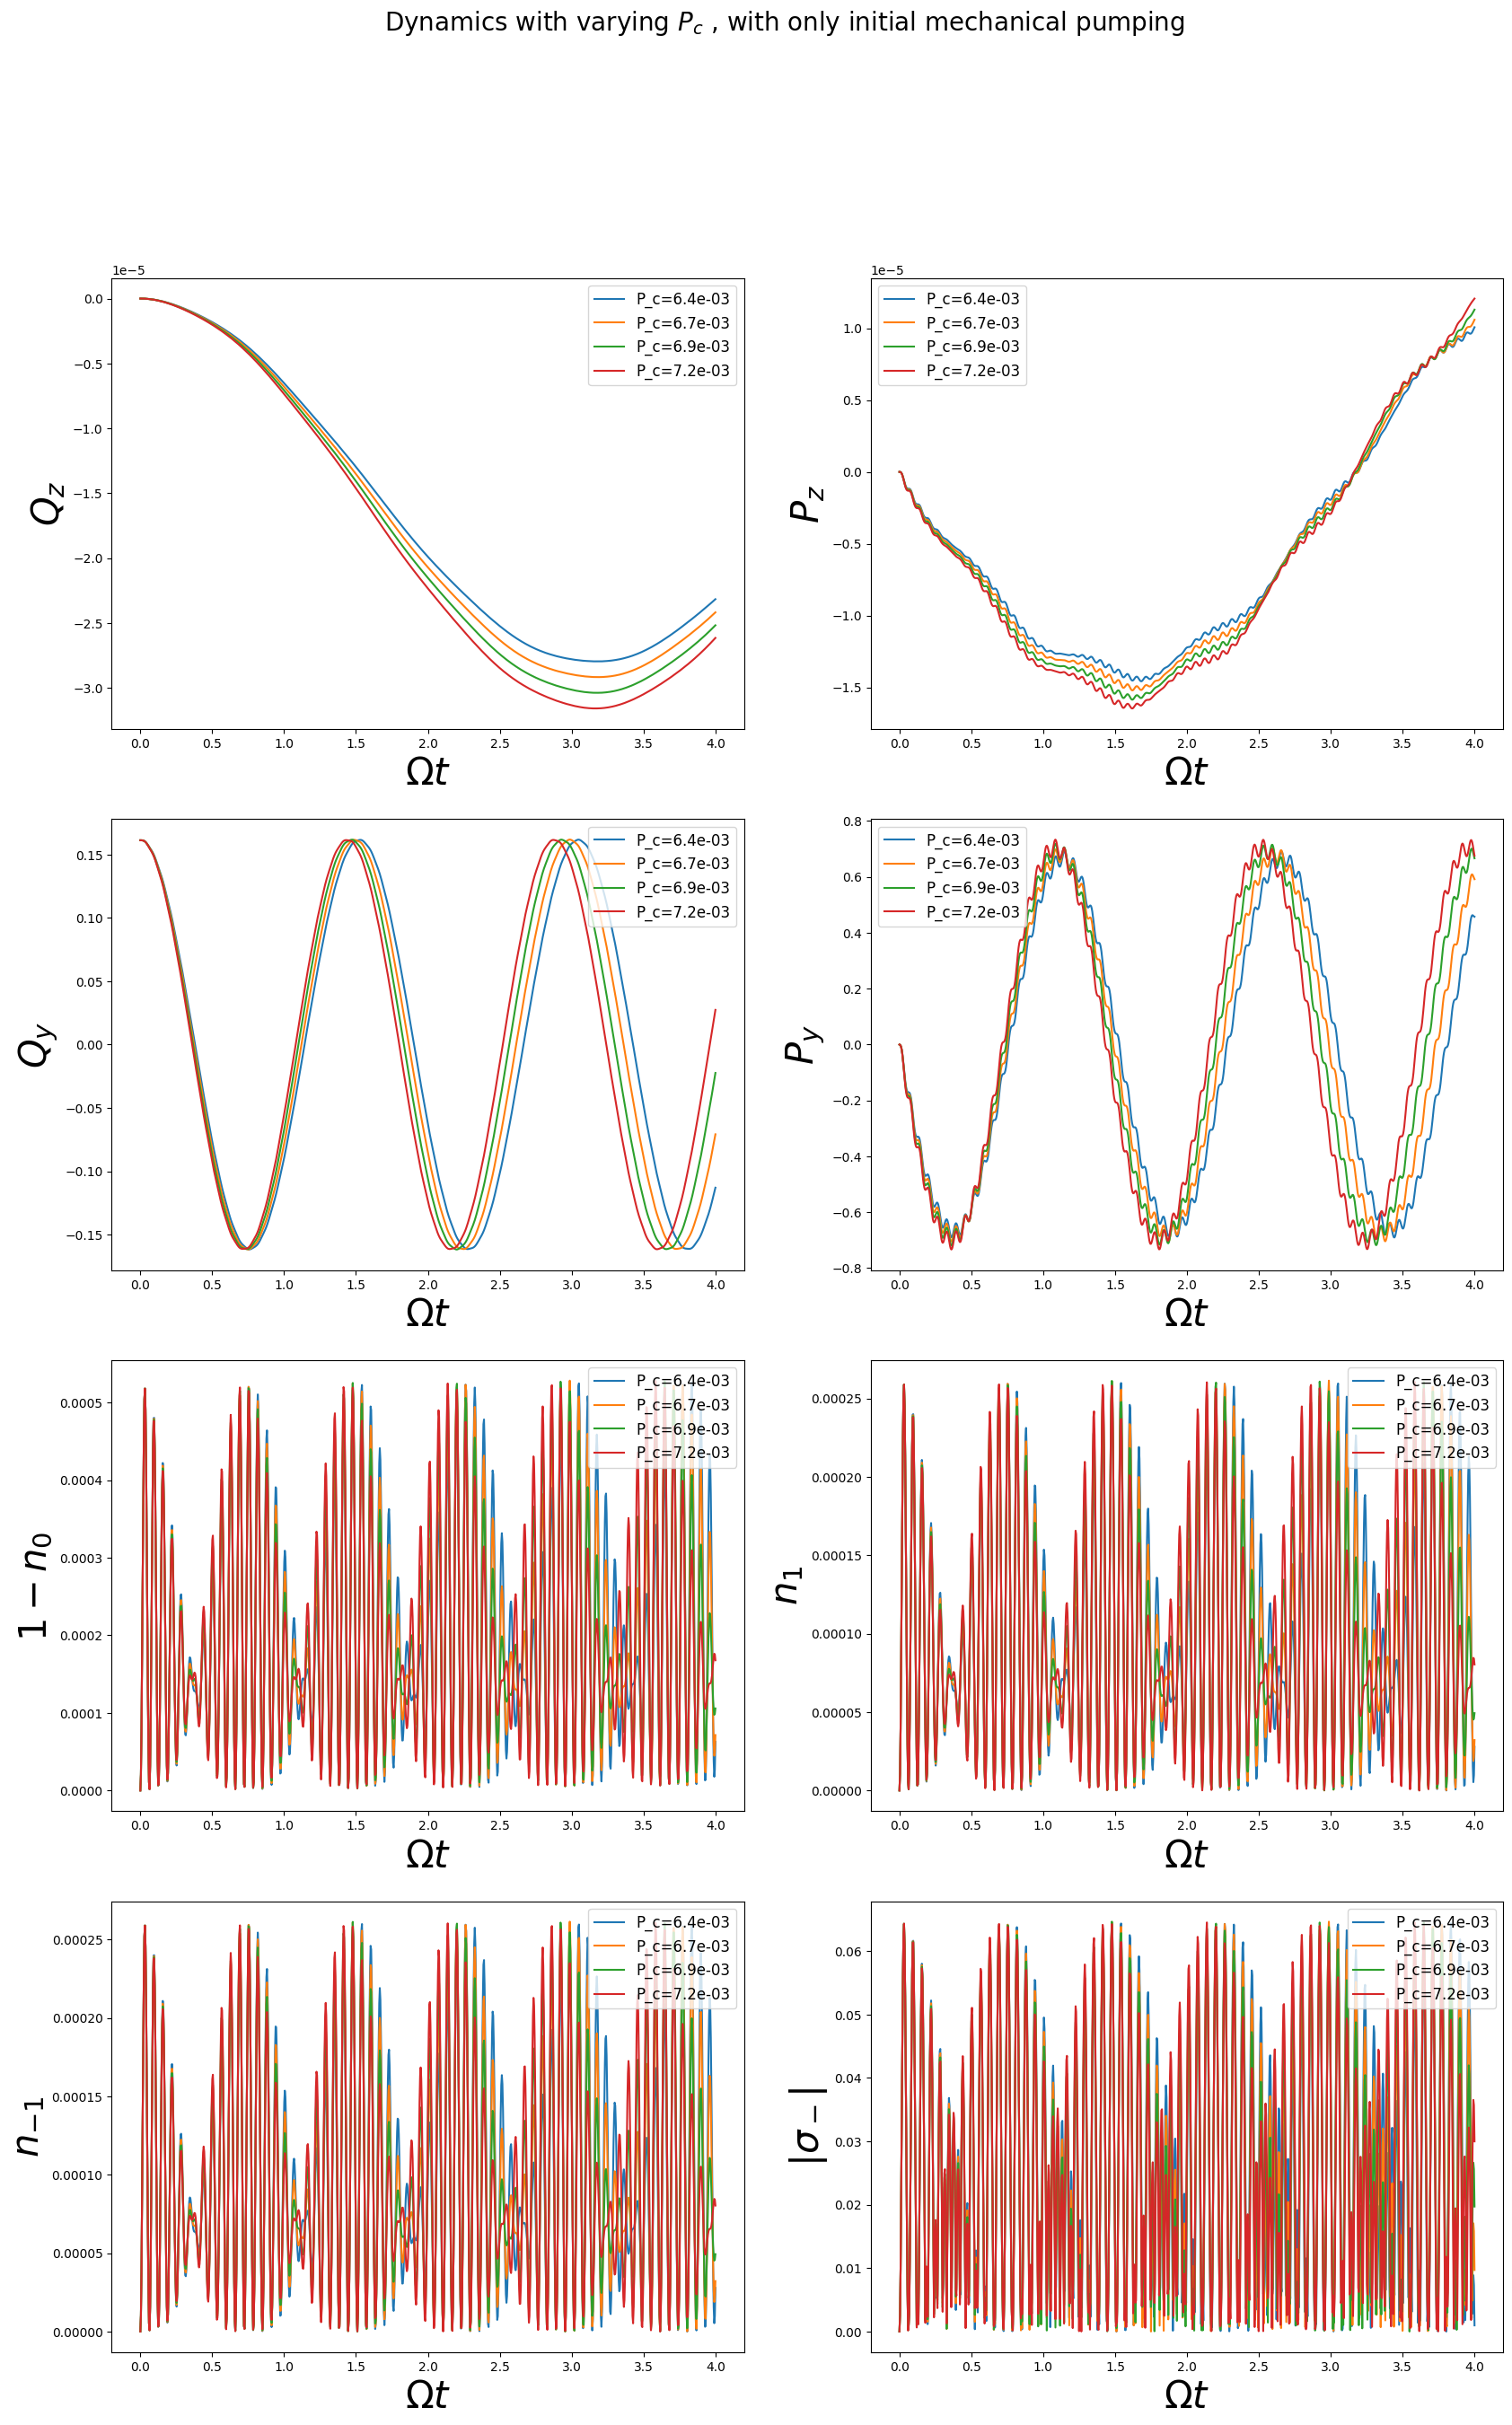

In [16]:
label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$1-n_0$","$n_1$","$n_{-1}$","$|\sigma_-|$"]

tf=4e0
N_step=1000
g_y=1e1
fig, axs = plt.subplots(4, 2,figsize=(20,30))
fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
N0_list=np.linspace(8,9,4)
x_0=[0.+0j,0.+0j,1.612*1e-1+0j,0.+0j]
psi_0=np.array([1+0j,0+0j,0+0j])

for N0 in (N0_list):
    param_list=[g_z0,g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    zz,t=evolve(x_0,psi_0,tf,param_list,N_step,linear=False)
    for i in range(8):
        axs[i//2,i%2].plot(t,zz[i],label="P_c"+'='+"{:.1e}".format(Pc(param_list)))
for i in range(8):
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
    axs[i//2,i%2].legend(fontsize=12)

plt.show() 

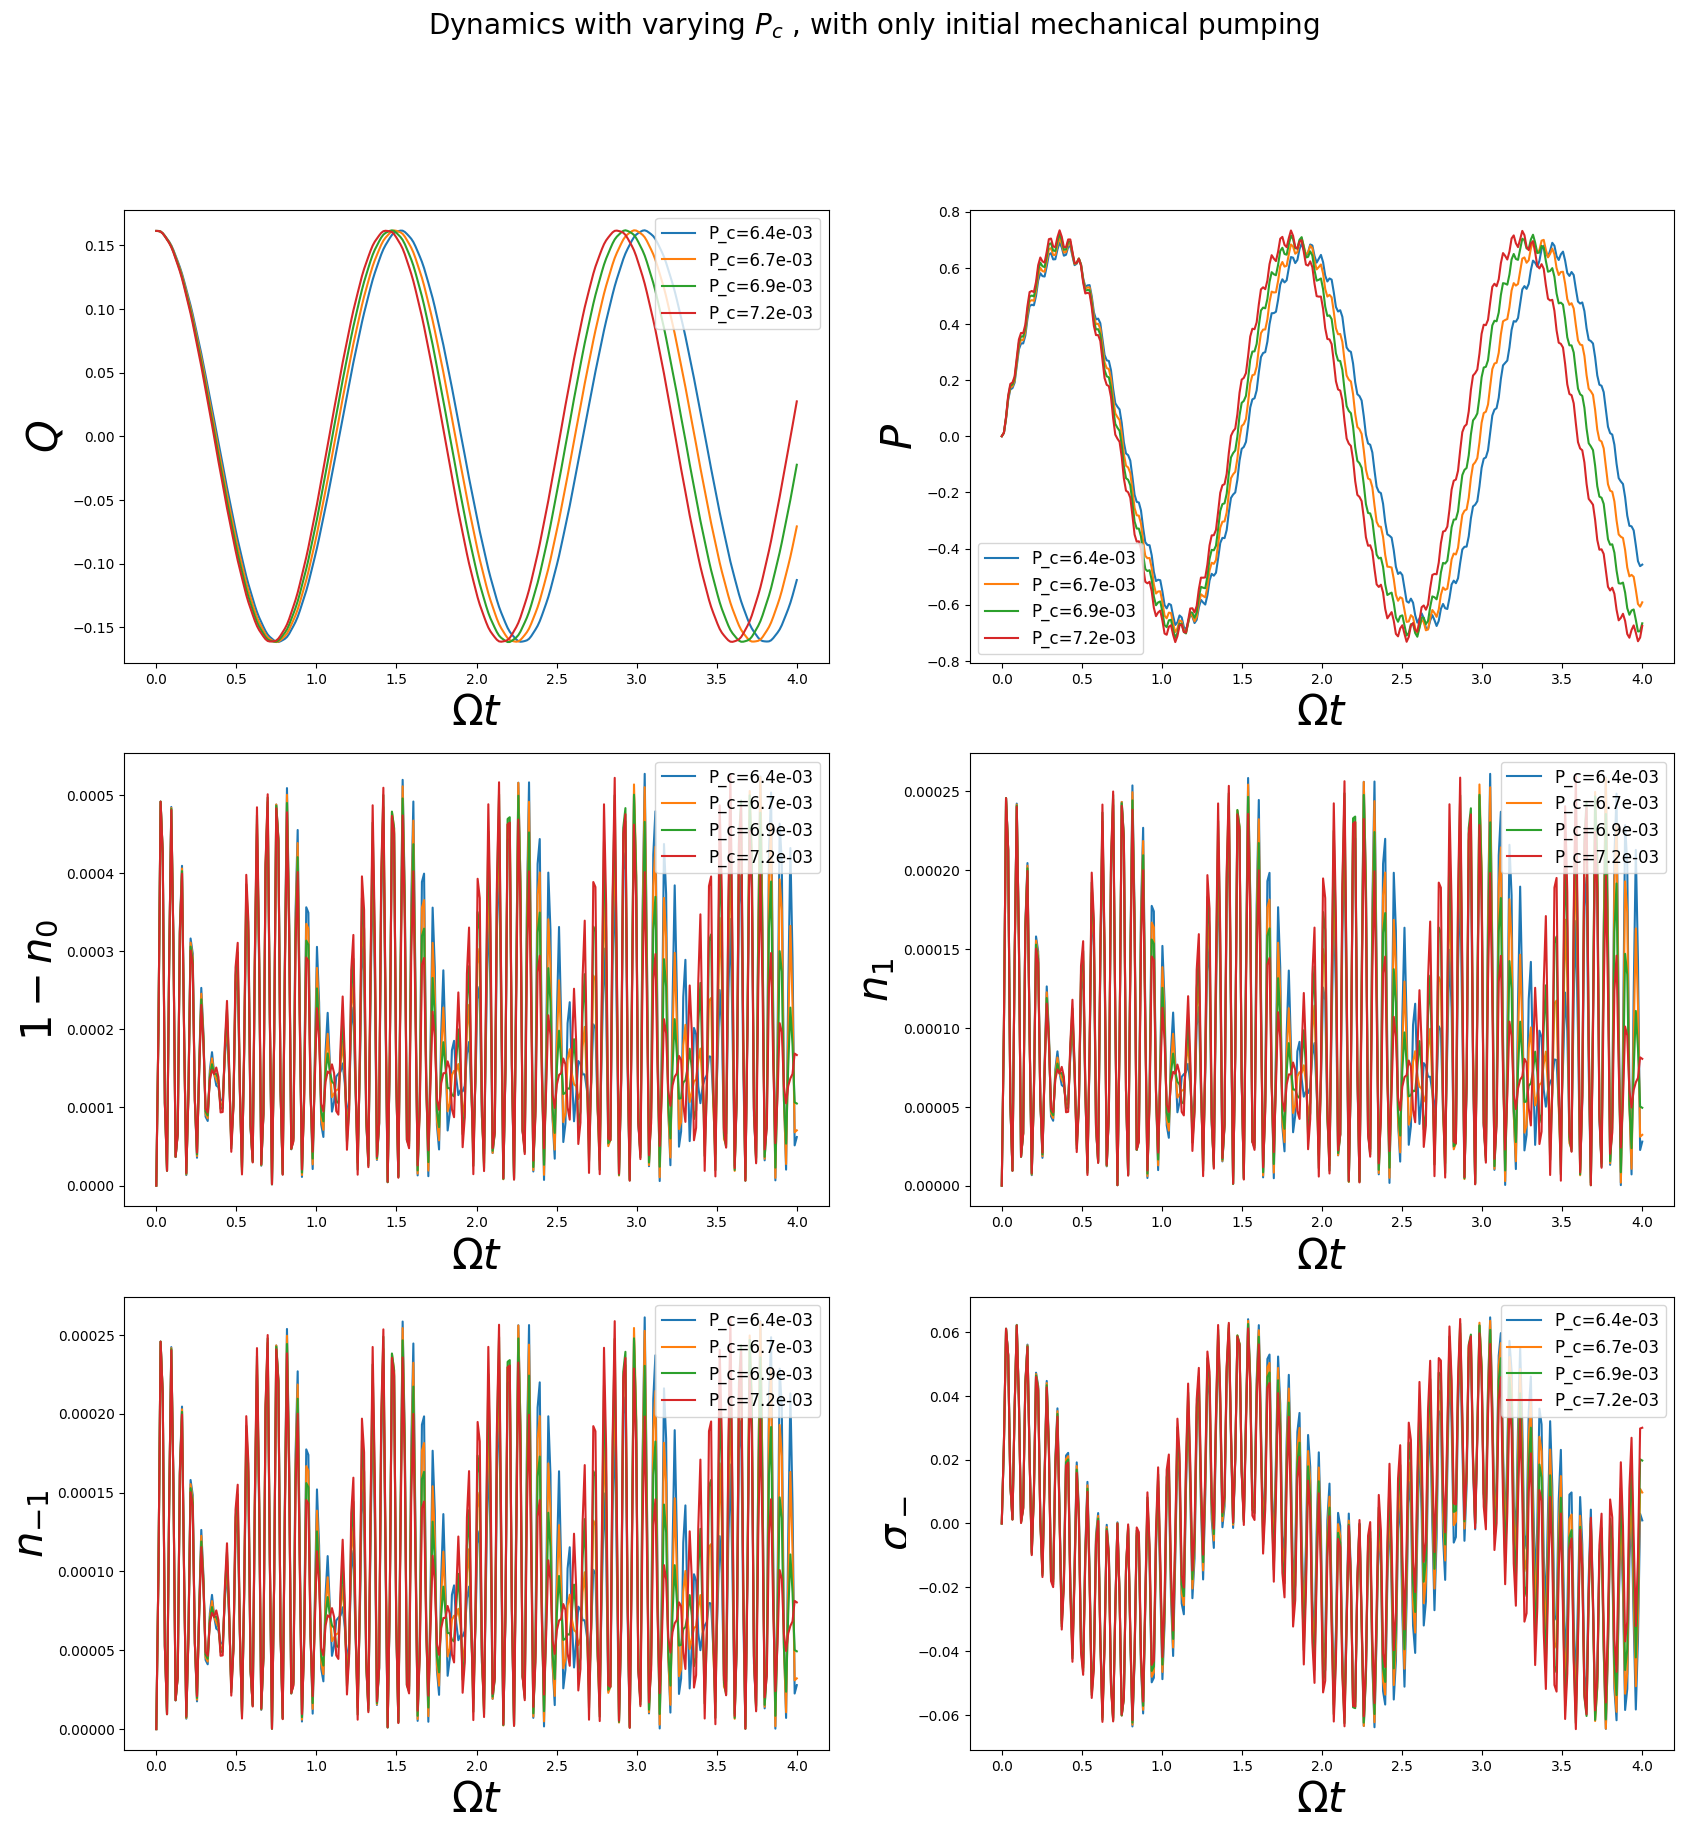

In [6]:
tf=4e0
N_step=300
g_y=1e1
fig, axs = plt.subplots(3, 2,figsize=(20,20))
fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
N0_list=np.linspace(8,9,4)
q_0,p_0=1.612*1e-1+0j,0.+0j
psi_0=np.array([1+0j,0+0j,0+0j])

for N0 in (N0_list):
    param_list=[g_z0,g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    zz,t=evolve(q_0,p_0,psi_0,tf,param_list,N_step,linear=False)
    for i in range(6):
        axs[i//2,i%2].plot(t,zz[i],label="P_c"+'='+"{:.1e}".format(Pc(param_list)))
for i in range(6):
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
    axs[i//2,i%2].legend(fontsize=12)

plt.show() 

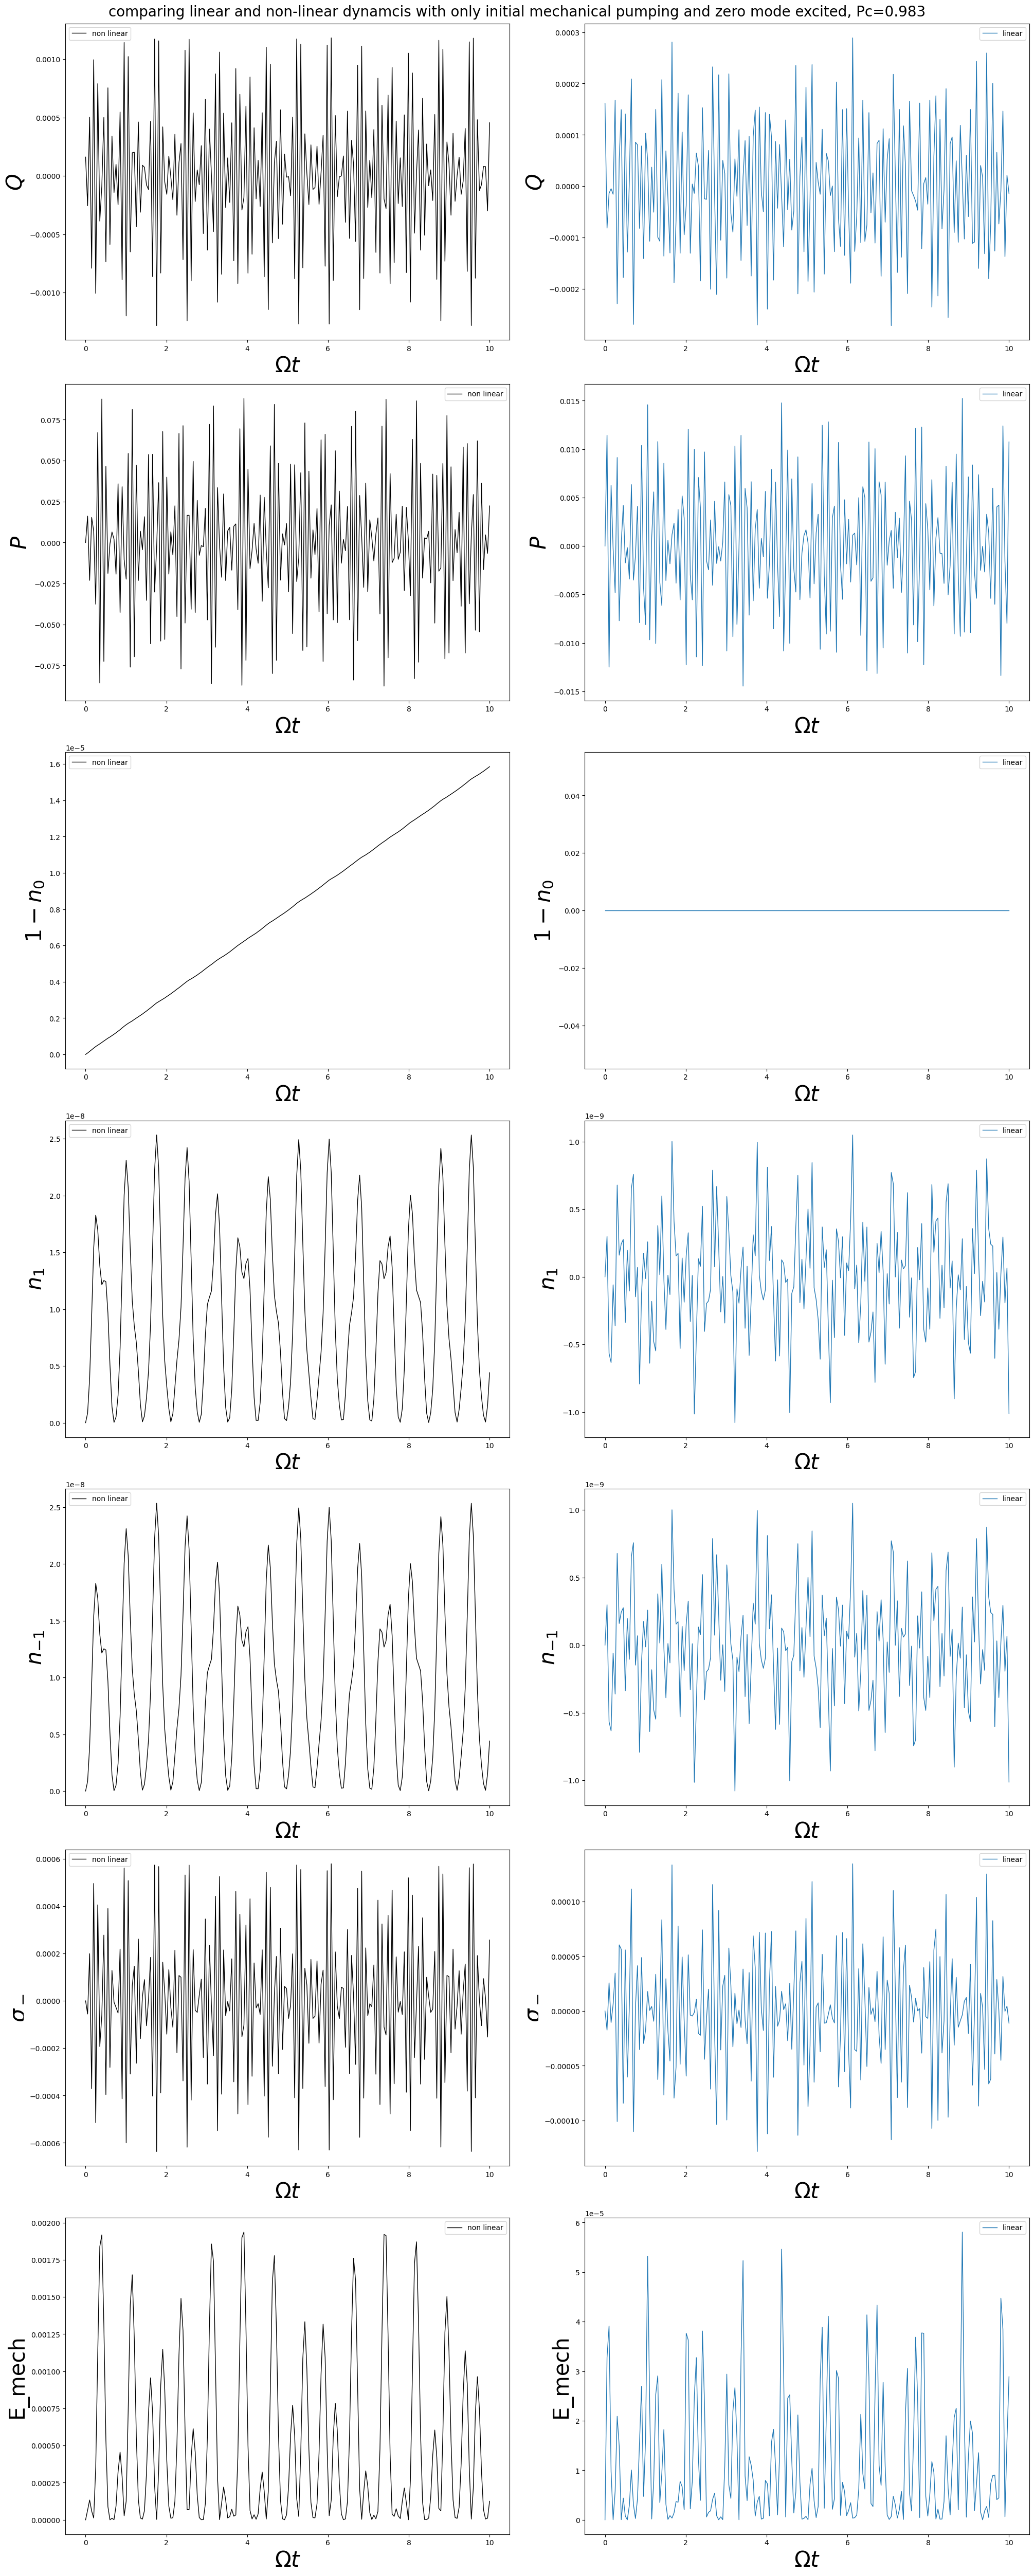

In [17]:
tf=1e1
g_y=1.24e7/ohm   ##Hz

q_0,p_0=1.612*1e-4+0j,0.+0j
psi_0=np.array([1+0j,0+0j,0+0j])
N_step=2*10**2
om=np.arange(N_step)
N0=800
param_list=[g_z0,g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq

zz_nl,t=evolve(q_0,p_0,psi_0,tf,param_list,N_step,linear=False)
zz_l,t=evolve(q_0,p_0,psi_0,tf,param_list,N_step,linear=True)
title="comparing linear and non-linear dynamcis with only initial mechanical pumping and zero mode excited, Pc={0}".format(np.round(Pc(param_list),3))
fig, axs = plt.subplots(7, 2,figsize=(20,50), constrained_layout=True)
fig.suptitle(title, fontsize=20)

for i in range(7):
    axs[i,0].plot(t,zz_nl[i],label="non linear",color='k',linewidth=1)
    axs[i,1].plot(t,zz_l[i],label="linear",linewidth=1)

for i in range(7):
    axs[i,0].set_ylabel(label_list[i],fontsize=30)
    axs[i,0].set_xlabel('$\Omega t$',fontsize=30)
    axs[i,0].legend(fontsize=10)
    axs[i,1].set_ylabel(label_list[i],fontsize=30)
    axs[i,1].set_xlabel('$\Omega t$',fontsize=30)
    axs[i,1].legend(fontsize=10)
    
plt.show() 